# Boston House Prices - A Regression Example
A regression problem requires that we predict a continuous value instead of a discreate label. In this case, we must predict the median house price in a Boston suburb in the mid-70s given 404 training samples and 102 test samples each of which has thirteen pieces of information such as the crime rate, property tax, etc which are all measured on different scales.

In [1]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 0s 0us/step


In [3]:
print("train_data:", train_data.ndim, train_data.shape, train_data.dtype)
print("train_target:", train_targets.ndim, train_targets.shape, train_targets.dtype)

train_data: 2 (404, 13) float64
train_target: 1 (404,) float64


In [4]:
print(train_data[0])
print(train_targets[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
15.2


## Preparing the Data
The standard way to prepare numeric data is feature-wise normalization over th etraining data. (Subtract the mean and divide by the standard deviation to give data that is centered around zero and has unit standard deviation.)

In [5]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data = (test_data - mean)/std

In [6]:
print("train_data:", train_data.ndim, train_data.shape, train_data.dtype)
print(train_data[0])

train_data: 2 (404, 13) float64
[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
  0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
  0.8252202 ]


## Build the Model
Because so few samples are available, we'll use a network with two hidden layers of 64 units to mitigate overfitting.

The network ends with a single unit and no activation (a linear layer.) We also use the mean-squared error loss function -- the square of the difference between the predictions and the target.

The "mae" -- Mean Absolute Error -- metric is the absolute value of the difference between the predictions and the targets e.g. an MAE of 0.5 would, in this case, mean the predictions are off by $500 on average.

In [12]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',
                 loss='mse',
                 metrics=['mae'])
    return model
    

## Validate the Model using K-Fold Validation
K-Fold Cross Validation is useful when you don't have many data points. Split the available data into K partions, instantiate K identical models, and train each one on K-1 partitions of data saving the last partition for validation. The vaildation score for the model is then the avarage of the K validation scores obtained.

In [15]:
import numpy as np

k = 4
num_val_samples = int(len(train_data)/4)
num_epochs = 100
all_scores = []
for i in range(k):
    print(i * num_val_samples,(i+1)*num_val_samples)
    val_data = train_data[i * num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i * num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]],
        axis = 0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis = 0)
    
    model = build_model()
    model.fit(partial_train_data,
             partial_train_targets,
             epochs=num_epochs,
             batch_size=1,
             verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

print(all_scores)
print(np.mean(all_scores))  

0 101
101 202
202 303
303 404
[2.4189403505608587, 2.939079553774088, 2.3995043239971197, 2.3934304277495584]
2.5377386640204063


### Save the validation logs at each epoch

In [22]:
import numpy as np

k = 4
num_val_samples = int(len(train_data)/4)
num_epochs = 500
all_scores = []
all_mae_histories = []
for i in range(k):
    print(i * num_val_samples,(i+1)*num_val_samples)
    val_data = train_data[i * num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i * num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]],
        axis = 0)
    
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis = 0)
    
    model = build_model()
    history = model.fit(partial_train_data,
                        partial_train_targets,
                        epochs=num_epochs,
                        batch_size=1,
                        validation_data=(val_data, val_targets),
                        verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]    


0 101
101 202
202 303
303 404


### Plotting the Validation Curve

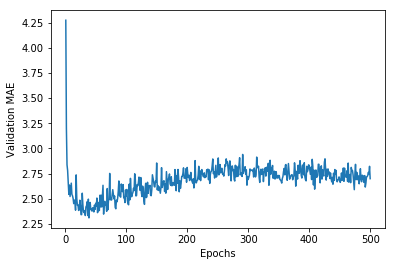

In [23]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### Smooth the Data
1. Omit the first ten data points
2. Replace each point with an exponential moving average of the previous points to get a smooth curve.

In [26]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

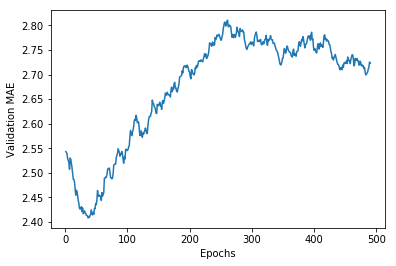

In [27]:
smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.clf
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving after 80 epochs.

### Build the Final Model

In [28]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

102/102 [==============================] - 0s 1ms/step
2.7905721103443817


So, after all that, you're still off by $2800 on average.